In [2]:
# prompt: insert drive to colab

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/MyDrive/gen3d/')

In [4]:
!ls

 3d-ddpm-chair+plane-vpred-axis-symmetry   __pycache__
 3d-ddpm-chair-vpred-axis-symmetry	   readme.md
 ddim_infer.py				   readme.md.gdoc
 demo.ipynb				   take_home_exercise.ipynb
 diffusion3d.py				  'Unconditional Generation of 3D Models.gdoc'
 infer.ipynb				  'Unconditional Generation of 3D Models.pdf'


In [ ]:
#!pip install torch==2.0.0
!pip install diffusers[training]
!pip install deepdish
!pip install plyfile
!pip install wandb

In [15]:
### visualization utility
import deepdish as dd
from matplotlib import pyplot as plt
import numpy as np
import plyfile
import os
from plyfile import PlyData, PlyElement

def save_to_ply( filename, points):
    assert points.ndim == 2 and points.shape[1] == 3, "Points should be a Nx3 array"

    vertex = np.array(
        [(p[0], p[1], p[2]) for p in points],
        dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4')]
    )

    ply_element = PlyElement.describe(vertex, 'vertex')

    PlyData([ply_element]).write(filename)

def get_coords(dims):
    x = np.linspace(-1, 1, dims)
    y = np.linspace(-1, 1, dims)
    z = np.linspace(-1, 1, dims)

    x_1, y_1, z_1 = np.meshgrid(x, y,z)
    return np.stack([x_1,y_1,z_1])


def plot_single_voxel_graph(ax,coords,voxels):
  mask = voxels[:,:,:] > 0

  points = np.array([coords[0,mask],coords[1,mask],coords[2,mask]]).T
  ax.scatter(points[:,0],points[:,1],points[:,2],s=1,vmin=-1,vmax=1,c='k')

  return points

def plot_voxels(voxels,save_ply=False):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  coords = get_coords(32)

  points =plot_single_voxel_graph(ax,coords,voxels)
  plt.show()

  if save_ply:
    save_to_ply('object.ply',points)


In [11]:
from diffusion3d import *
from diffusers.utils.torch_utils import randn_tensor

### script for inferencing, performs DDIM 50 step inference for batch size of 16

In [12]:

def scheduler_to_device(scheduler,device):
    scheduler.betas = scheduler.betas.to(device)
    scheduler.alphas_cumprod = scheduler.alphas_cumprod.to(device)
    scheduler.final_alpha_cumprod = scheduler.final_alpha_cumprod.to(device)

config = TrainingConfig()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = Unet3D(init_dim=32,dim=32,dim_mults=[1,2,4,8])
model.load_state_dict(torch.load(os.path.join(config.output_dir, 'model')))
model.eval()

bs = 16
generator = torch.Generator(device=device)
scheduler = DDIMScheduler.from_config(config.scheduler_config,rescale_betas_zero_snr=True,
                                      timestep_spacing="trailing",prediction_type = "v_prediction")
scheduler.set_timesteps(num_inference_steps=50,device=device)
scheduler_to_device(scheduler,device)

with torch.no_grad():
  image = randn_tensor((bs,1,config.image_size,config.image_size,config.image_size),device=device, generator=generator)
  #torch.randn((1,1,config.image_size,config.image_size,config.image_size),device=device)
  for t in tqdm(scheduler.timesteps[:,None]):
      # 1. predict noise model_output
      model_output = model(image, t)
      # 2. predict previous mean of image x_t-1 and add variance depending on eta
      # eta corresponds to η in paper and should be between [0, 1]
      # do x_t -> x_t-1
      image = scheduler.step(
          model_output, t, image, eta=0, use_clipped_model_output=True, generator=generator
      ).prev_sample

#torch.save(image.detach().cpu().numpy(),os.path.join(config.output_dir, 'gen-32-ddim-final.pt'))


  0%|          | 0/50 [00:00<?, ?it/s]

min value:  -1.0
max value:  1.0
Voxel data shape: (32, 32, 32)
Voxel value (0,0,0): -0.99097407
Voxel value (15,15,15): -0.9928735


<ipython-input-15-3b572b138220>:34: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(points[:,0],points[:,1],points[:,2],s=1,vmin=-1,vmax=1,c='k')


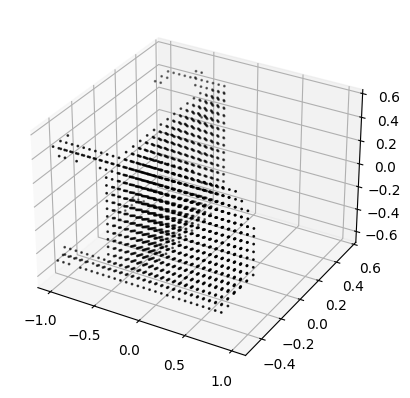

In [18]:
voxels = image.detach().cpu().numpy()[1,0]
print("min value: ",voxels.min())
print("max value: ",voxels.max())
#voxels = voxels*2/(voxels.max()-voxels.min())
print('Voxel data shape:',voxels.shape)
print('Voxel value (0,0,0):', voxels[0,0,0])
print('Voxel value (15,15,15):', voxels[15,15,15])

plot_voxels(voxels)

## Training script without wandb logging, batch size 16

#### I've added few samples from the train dataset for demo training run

In [19]:
config.train_batch_size = 16
config.num_epochs = 5
config.input_dir = "3d-ddpm-chair+plane-vpred-axis-symmetry"
config.output_dir = "new-dir"

In [23]:
import pathlib
from diffusers.optimization import get_cosine_schedule_with_warmup

In [25]:
### create output dir
pathlib.Path(config.output_dir).mkdir(parents=True, exist_ok=True)

### dataloader
dataset = VoxelDataset(root_dir='shape_net_voxel_data_v1')
dataloader = DataLoader(dataset, batch_size=config.train_batch_size,
                        shuffle=True,num_workers=5,persistent_workers=True,
                        pin_memory=False)

### loading model
model = Unet3D(init_dim=32,dim=32,dim_mults=[1,2,4,8])
if os.path.isfile(os.path.join(config.input_dir, 'model')):
    model.load_state_dict(torch.load(os.path.join(config.input_dir, 'model')))

optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(dataloader) * config.num_epochs),
)

noise_scheduler = DDIMScheduler.from_config(config.scheduler_config)
scheduler_to_device(noise_scheduler,device)
for epoch in range(config.num_epochs):
    model.train()
    with tqdm(dataloader, unit="batch", leave=False) as tepoch:
        for  batch in tepoch:
            tepoch.set_description(f"Epoch: {epoch}")
            clean_images = batch.to(device).unsqueeze(1)
            # Sample noise that we'll add to the images
            noise = torch.randn(clean_images.shape,device=device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
            ).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            ### weighting term of SNR+1
            # weights = 1 + (noise_scheduler.alphas[timesteps])**2/(1 - (noise_scheduler.alphas[timesteps])**2)
            # weights = torch.sqrt(weights).view(-1,1,1,1,1)

            with torch.set_grad_enabled(True):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps)

                if noise_scheduler.config.prediction_type == "v_prediction":

                    v_pred = noise_scheduler.get_velocity(clean_images,noise,timesteps)
                    v_recon = get_orig_from_velocity(noise_pred,timesteps,noisy_images,noise_scheduler)
                    # loss = F.huber_loss(weights*noise_pred, weights*v_pred)
                    loss = F.huber_loss(noise_pred, v_pred)

                elif noise_scheduler.config.prediction_type == "epsilon":
                    # loss = F.huber_loss(weights*noise_pred, weights*noise)
                    loss = F.huber_loss(noise_pred, noise)
                    v_recon = noisy_images - noise_pred

                elif noise_scheduler.config.prediction_type == "sample":
                    # loss = F.huber_loss(weights*noise_pred, weights*clean_images)
                    loss = F.huber_loss(noise_pred, clean_images)
                    v_recon = noise_pred

                ### axis of symmetry loss, where upper and lower halves should be mirror images of each other
                loss += F.huber_loss(v_recon[...,:config.image_size//2],
                                      torch.flip(v_recon[...,config.image_size//2:],dims=[-1]))

                loss.backward()
                optimizer.step()
                lr_scheduler.step()
                # if config.use_ema:
                #     ema_model.step(model)
                optimizer.zero_grad()

            tepoch.set_postfix(loss=loss.item())
            # wandb.log({"train_mse": loss.item(),
            #             "learning_rate": lr_scheduler.get_last_lr()[0],
            #             #"ema_decay":ema_model.decay
            #             })

        if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
            eval(model,config,epoch)
        if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
            torch.save(model.state_dict(), os.path.join(config.output_dir, 'model'))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/50 [00:00<?, ?it/s]